In [11]:
import os
import sys
import pathlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import torch

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import NLinearModel, NBEATSModel, AutoARIMA, NaiveMovingAverage, \
            Prophet, LightGBMModel, ExponentialSmoothing, FFT, Theta

from darts.utils.missing_values import fill_missing_values
from darts.metrics.metrics import mae, mape
from darts.dataprocessing.transformers import Scaler

from pytorch_lightning.callbacks.early_stopping import EarlyStopping

PROJECT_FOLDER = pathlib.Path(os.getcwd()).resolve().parent
DATA_FOLDER = PROJECT_FOLDER / 'data'
sys.path.append(str(PROJECT_FOLDER / 'src'))
from utils.dataset_utils import DatasetUtils

sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

style.use('seaborn-poster')
style.use('ggplot')

/tmp/ipykernel_2788/1337998922.py:31: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-poster')


# Конфиг

In [2]:
PATH_TO_STOCKS = PROJECT_FOLDER / 'data' / 'SBER_210111_230531.csv'
TEST_SIZE = 0.1
VAL_SIZE = 0.25

INPUT_CHUNK = 128
OUTPUT_CHUNK = 20
EARLYSTOP_PATIENCE = 20
LOSS_FN = torch.nn.L1Loss()

# Загрузка данных

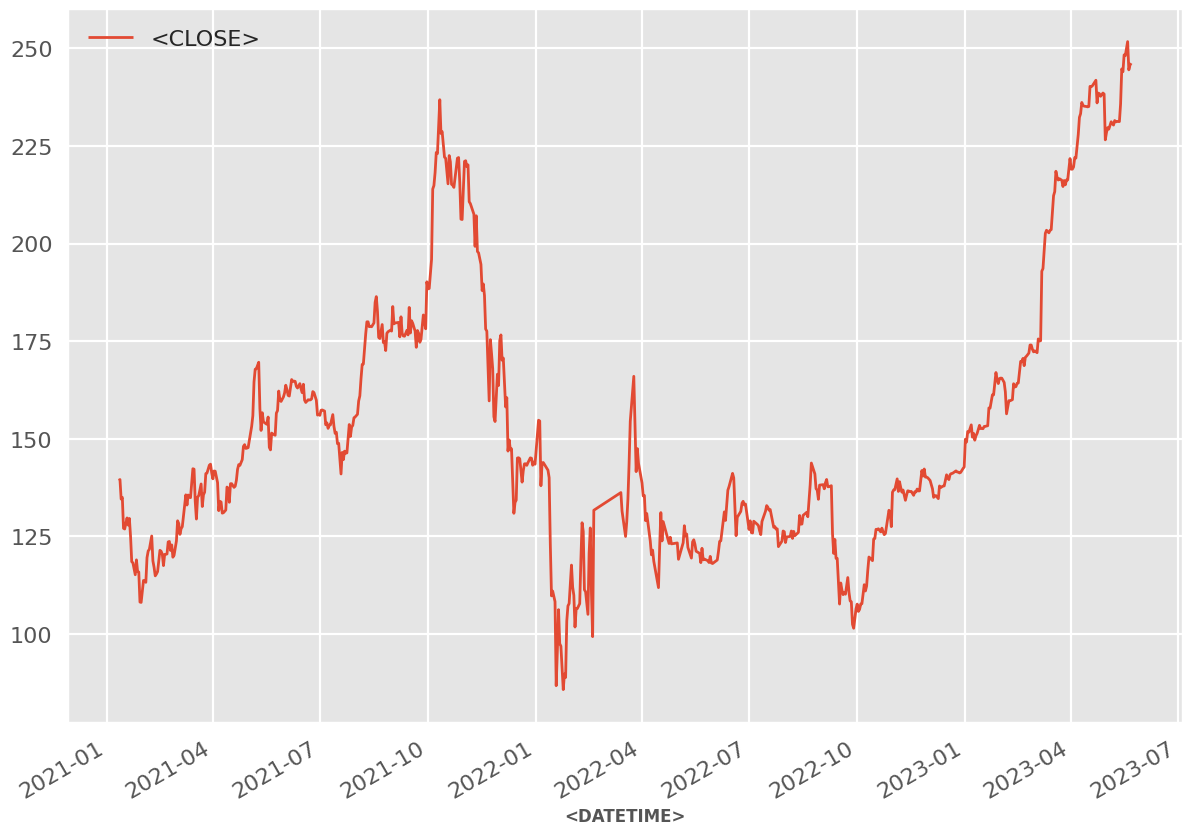

In [3]:
dataset_utils = DatasetUtils()
example_stocks = dataset_utils.create_daily_dart_timeseries(PATH_TO_STOCKS, remove_structural=True)
example_stocks.plot()

# Целевые модели

In [ ]:
baseline_model = NaiveMovingAverage()
baseline_model.fit(example_stocks)
baseline_model.historical_forecasts(example_stocks, start=.5, forecast_horizon=32).plot()
example_stocks.plot()

In [ ]:
# def backtest_model(model, series: TimeSeries):
import logging
from tabnanny import verbose
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

def eval_model(model, train_series: TimeSeries, val_series: TimeSeries):
    model.fit(train_series)
    forecast = model.predict(len(val_series))
    print(f'{model} MAPE = {mape(val_series, forecast)}')

def evaluate_models(data_folder: pathlib.Path, test_size: float = 0.1, val_size: float = 0.1, forecast_horizon: int = 16):
    plt.figure(figsize=(15, 30))
    for idx, file_name in enumerate(data_folder.iterdir()):
        if file_name.stem == '.gitkeep':
            continue
        company_name = file_name.stem.split('_')[0]
        stocks_timeseries = dataset_utils.create_daily_dart_timeseries(file_name, remove_structural=True)
        train_series, val_series, test_series = dataset_utils.get_train_val_test_split(stocks_timeseries, test_size, val_size)
        model = NaiveMovingAverage()

        print(f'Starting backtest for {company_name}')
        # Backtesting the model
        historical_forecast = model.historical_forecasts(
            stocks_timeseries,
            start=0.9,
            forecast_horizon=forecast_horizon,
        )

        # Prophet
        model_prophet = Prophet()

        ## HF
        historical_forecast_prophet = model_prophet.historical_forecasts(
            stocks_timeseries,
            start=0.9,
            forecast_horizon=forecast_horizon,
            verbose=False
        )

        # LightGBM
        model_lgbm = LightGBMModel(
            lags=64,
            output_chunk_length=forecast_horizon,
            random_state=42,
            n_jobs=-1
        )
        ## HD
        historical_forecast_lgbm = model_lgbm.historical_forecasts(
            stocks_timeseries,
            start=0.9,
            forecast_horizon=forecast_horizon,
            verbose=False
        )


        # Plotting
        plt.subplot(6, 3, idx + 1)
        plt.title(company_name)
        
        mape_err = mape(historical_forecast, stocks_timeseries)
        mape_err_prophet = mape(historical_forecast_prophet, stocks_timeseries)
        mape_err_lgbm = mape(historical_forecast_lgbm, stocks_timeseries)

        historical_forecast.plot(label=f'naive_ma_{company_name}, MAPE = {round(mape_err, 2)}%')
        historical_forecast_prophet.plot(label=f'prophet_{company_name}, MAPE = {round(mape_err_prophet, 2)}%')
        historical_forecast_lgbm.plot(label=f'lgbm_{company_name}, MAPE = {round(mape_err_lgbm, 2)}%')
        stocks_timeseries.plot(label=f'y_{company_name}')
        return ...
    plt.tight_layout()
    plt.show()
evaluate_models(DATA_FOLDER)

Starting initial tests for AFLT
Best mape = 0.59% achived by Theta()
-----
Starting initial tests for ALRS
Best mape = 0.89% achived by ExponentialSmoothing()
-----
Starting initial tests for GAZP
Best mape = 0.98% achived by Theta()
-----
Starting initial tests for GMKN


/home/migisen/Study/misis-dshack/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Best mape = 1.23% achived by AutoARIMA()
-----
Starting initial tests for HYDR
Best mape = 1.24% achived by ExponentialSmoothing()
-----
Starting initial tests for IRAO
Best mape = 1.37% achived by AutoARIMA()
-----
Starting initial tests for LKOH
Best mape = 6.93% achived by ExponentialSmoothing()
-----
Starting initial tests for MGNT
Best mape = 1.65% achived by ExponentialSmoothing()
-----
Starting initial tests for MOEX
Best mape = 3.85% achived by Prophet()
-----
Starting initial tests for MTLR
Best mape = 2.66% achived by ExponentialSmoothing()
-----
Starting initial tests for MTSS
Best mape = 0.55% achived by NaiveMovingAverage(1)
-----
Starting initial tests for NLMK
Best mape = 2.83% achived by AutoARIMA()
-----
Starting initial tests for ROSN
Best mape = 1.87% achived by NaiveMovingAverage(1)
-----
Starting initial tests for RTSI
Best mape = 5.85% achived by ExponentialSmoothing()
-----
Starting initial tests for SBER
Best mape = 0.9% achived by ExponentialSmoothing()
-----
S

ValueError: num must be an integer with 1 <= num <= 18, not 20

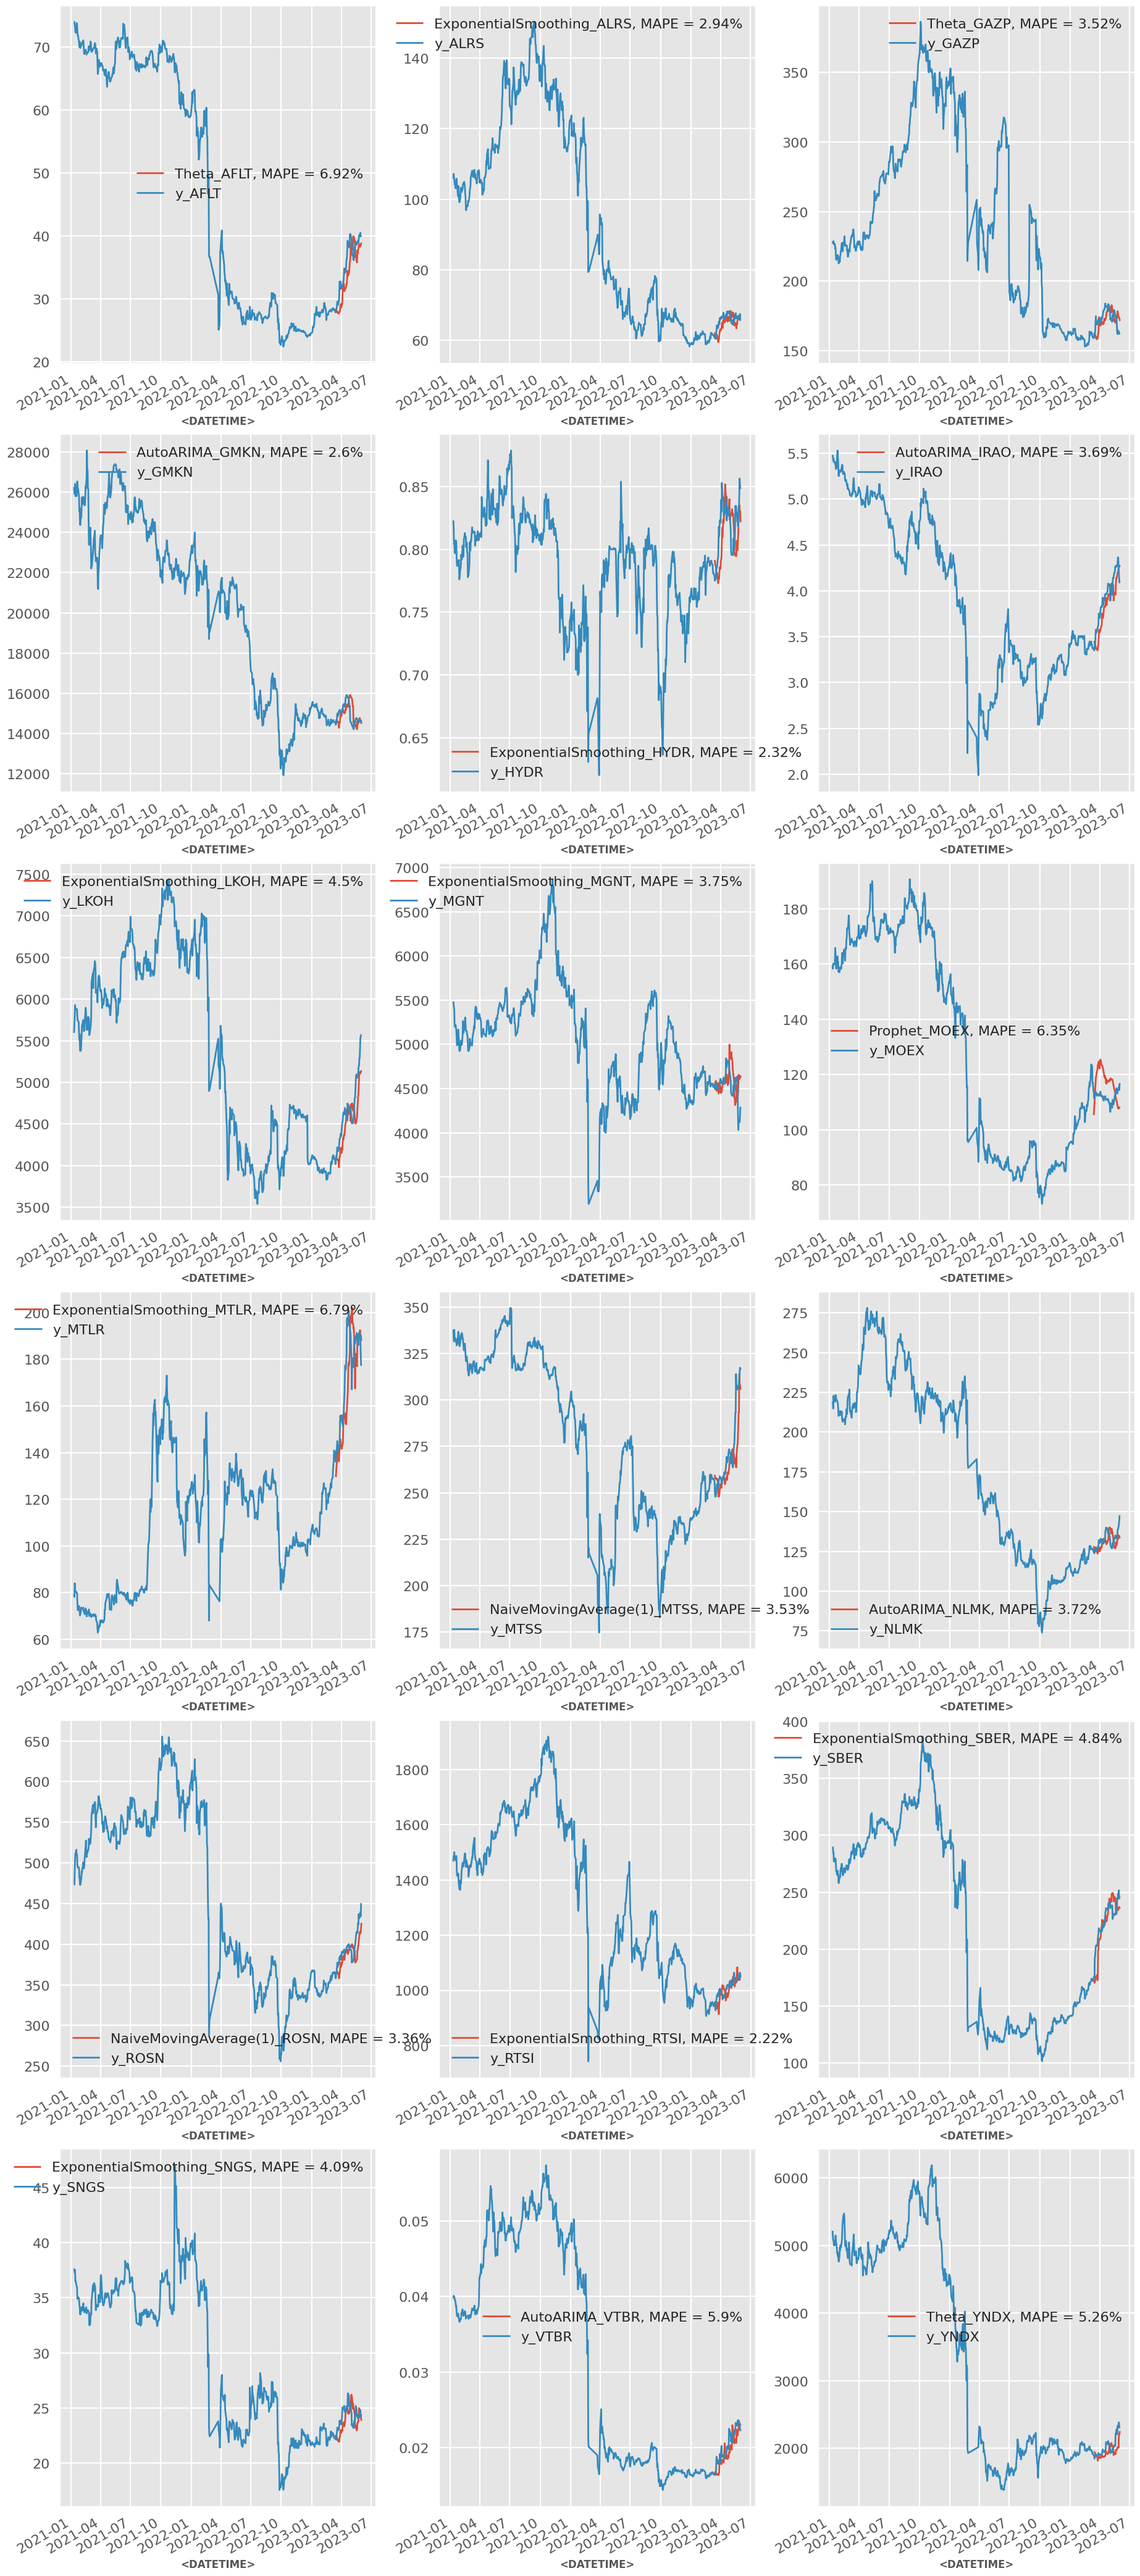

In [14]:
# def backtest_model(model, series: TimeSeries):
import logging
from tabnanny import verbose
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

def eval_model(model, train_series: TimeSeries, val_series: TimeSeries):
    model.fit(train_series)
    forecast = model.predict(len(val_series))
    models_mape = mape(val_series, forecast)
    # print(f'{model} MAPE = {models_mape}')
    return models_mape

def evaluate_models(data_folder: pathlib.Path, test_size: float = 0.1, val_size: float = 0.1, forecast_horizon: int = 10, remove_structural: bool = False):
    plt.figure(figsize=(20, 50))
    for idx, file_name in enumerate(data_folder.iterdir()):
        if file_name.stem == '.gitkeep':
            continue
        plt.subplot(6, 3, idx + 1)
        company_name = file_name.stem.split('_')[0]
        stocks_timeseries = dataset_utils.create_daily_dart_timeseries(file_name, remove_structural=remove_structural)
        train_series, val_series, test_series = dataset_utils.get_train_val_test_split(stocks_timeseries, test_size, val_size)
        print(f'Starting initial tests for {company_name}')
        models = [
            ExponentialSmoothing(),
            FFT(),
            Prophet(),
            AutoARIMA(),
            Theta(),
            NaiveMovingAverage()
        ]
        mapes = np.zeros(len(models))
        for idx, model in enumerate(models):
            models_mape = eval_model(model, train_series=train_series, val_series=val_series[:forecast_horizon])
            mapes[idx] = models_mape
        best_mape_idx = np.argmin(mapes)
        print(f'Best mape = {round(mapes[best_mape_idx], 2)}% achived by {models[best_mape_idx]}')

        # Running backtest for best model
        historical_backtest = models[best_mape_idx].historical_forecasts(
            stocks_timeseries,
            start=0.9,
            forecast_horizon=forecast_horizon,
            verbose=False
        )
        mape_err = mape(historical_backtest, stocks_timeseries)
        
        # Plotting
        
        plt.title(company_name)

        best_model_name = str(models[best_mape_idx]).split("(")[0]
        historical_backtest.plot(label=f'{best_model_name}_{company_name}, MAPE = {round(mape_err, 2)}%')
        stocks_timeseries.plot(label=f'y_{company_name}')
        
        # Saving
        
        if remove_structural:
            predictions_filename = f'{company_name}_{best_model_name}_pred_wostruct_d.csv'
            daily_data_filename = f'{company_name}_wostruct_d.csv'
        else:
            predictions_filename = f'{company_name}_{best_model_name}_pred_d.csv'
            daily_data_filename = f'{company_name}_d.csv'
        
        historical_backtest.to_csv(data_folder / 'predictions' / predictions_filename)
        stocks_timeseries.to_csv(data_folder / 'predictions' / daily_data_filename)
        print(5*'-')
evaluate_models(DATA_FOLDER)

Starting initial tests for AFLT
Best mape = 0.53% achived by NaiveMovingAverage(1)
-----
Starting initial tests for ALRS
Best mape = 1.35% achived by ExponentialSmoothing()
-----
Starting initial tests for GAZP
Best mape = 0.89% achived by ExponentialSmoothing()
-----
Starting initial tests for GMKN


/home/migisen/Study/misis-dshack/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Best mape = 1.44% achived by ExponentialSmoothing()


/home/migisen/Study/misis-dshack/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/migisen/Study/misis-dshack/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/migisen/Study/misis-dshack/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/migisen/Study/misis-dshack/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/migisen/Study/misis-dshack/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home

-----
Starting initial tests for HYDR
Best mape = 1.1% achived by Prophet()
-----
Starting initial tests for IRAO
Best mape = 0.97% achived by Theta()
-----
Starting initial tests for LKOH
Best mape = 8.95% achived by FFT()
-----
Starting initial tests for MGNT
Best mape = 1.31% achived by ExponentialSmoothing()
-----
Starting initial tests for MOEX
Best mape = 4.04% achived by FFT()
-----
Starting initial tests for MTLR
Best mape = 1.83% achived by FFT()
-----
Starting initial tests for MTSS
Best mape = 0.46% achived by NaiveMovingAverage(1)
-----
Starting initial tests for NLMK
Best mape = 3.17% achived by FFT()
-----
Starting initial tests for ROSN
Best mape = 2.83% achived by AutoARIMA()
-----
Starting initial tests for RTSI
Best mape = 2.04% achived by FFT()
-----
Starting initial tests for SBER
Best mape = 1.55% achived by AutoARIMA()
-----
Starting initial tests for SNGS
Best mape = 1.25% achived by AutoARIMA()
-----
Starting initial tests for VTBR


/home/migisen/Study/misis-dshack/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/home/migisen/Study/misis-dshack/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


Best mape = 2.4% achived by Prophet()
-----
Starting initial tests for YNDX
Best mape = 1.06% achived by AutoARIMA()
-----


ValueError: num must be an integer with 1 <= num <= 18, not 20

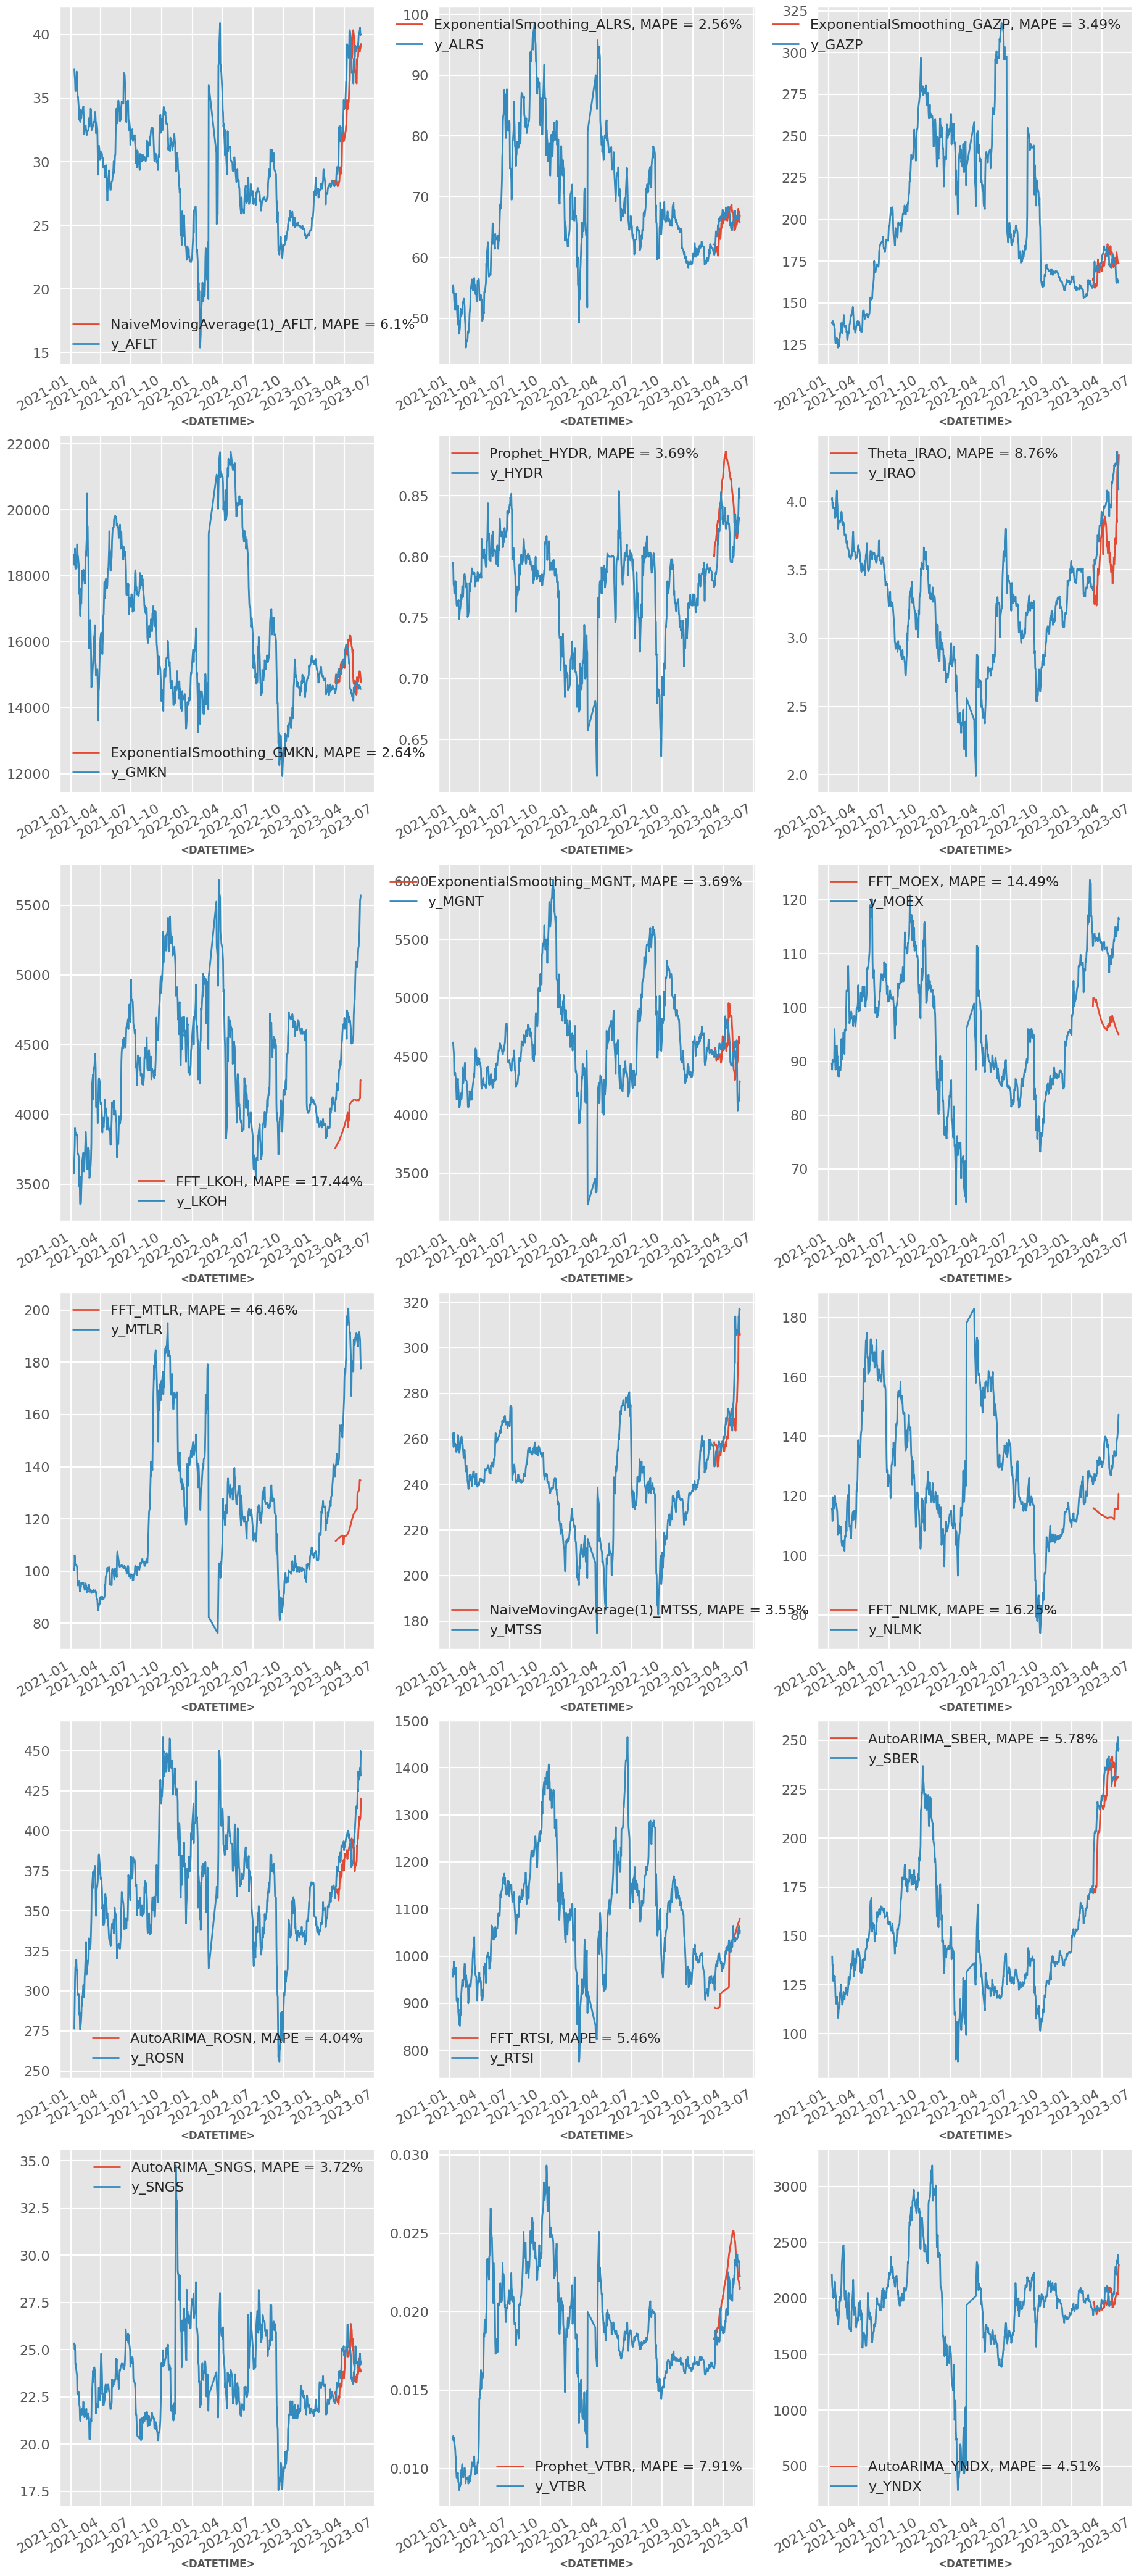

In [15]:
evaluate_models(DATA_FOLDER, remove_structural=True)